In [1]:
import requests
from bs4 import BeautifulSoup
from pathlib import Path
import time
import re
from datetime import datetime
import os
from nltk.corpus import stopwords
import pandas as pd
import math
import json
import string
import nltk
from nltk.stem import LancasterStemmer
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ADM/HM3/pages.zip

# Functions

In [ ]:
# function that returns number of episodes, type anime, releaseDate,endDate
def get_information(soup):
  lista = soup.find_all("div", class_="spaceit_pad")
  type_anime =""
  episode = 0
  releaseDate =""
  endDate = ""
  for el in lista:
    if el.find('span'):
      if el.span.text == "Type:":
        type_anime = el.a.text
      elif el.span.text == "Episodes:":
        episode = [int(s) for s in el.text.split() if s.isdigit()][0]
      elif el.span.text == "Aired:":
        line = re.sub("(\nAired:\n) | *(\n)", '', el.text).split('to')
        if len(line) > 0:
          # convert string to datatime
          releaseDate = datetime.strptime(line[0].lower().strip(),"%b %d, %Y")
          if len(line) > 1:
            endDate = datetime.strptime(line[1].lower().strip(),"%b %d, %Y")
  return type_anime,episode,releaseDate,endDate

In [ ]:
# generic function that return the text that contain in a specific tag and specific class
def find_element_by_class(class_name,tag_name):
  lista = soup.find_all(tag_name, class_=class_name)
  final_list = []
  set_control = set()
  for el in lista:
      if el.a.text not in set_control:
        set_control.add(el.a.text)
        final_list.append(el.a.text)    
  return final_list

In [ ]:
# function that return the Related Anime that contain in a specific tag and specific class
def find_anime(class_name,tag_name,child_class,bool_href):
  lista = soup.find(tag_name, class_=class_name).find_all(child_class,href=bool_href)
  final_list = []
  set_control = set()
  for el in lista:
    if el.text not in set_control:
          set_control.add(el.text)
          final_list.append(el.text)
  return final_list

In [ ]:
# function that return the staff 
def find_staff(tag_name, text, tag_sibling, tag_full_name, tag_role):
  staff_table = soup.find(tag_name, text=text).parent.find_next_sibling()
  lista = []
  for el in staff_table.find_all(tag_sibling):
    full_name = el.find_all(tag_full_name)[1].text
    role = el.find(tag_role).text
    lista.append([full_name,role])
  return lista

In [ ]:
# function that elaborate a file html and return a line that contains some information about the page
def descrip_html(path):
  with open(path) as myfile:
      soup = BeautifulSoup(myfile)
  
  title_name =soup.find("h1", class_="title-name").strong.text if soup.find("h1", class_="title-name") is not None else ""
  type_anime,episode,releaseDate,endDate = get_information(soup)
  score = soup.find("div", class_="fl-l score").text if soup.find("div", class_="fl-l score") is not None else ""
  num_members = soup.find("span", class_="numbers members").strong.text.replace(",","") if soup.find("span", class_="numbers members") is not None else ""
  userCount =  soup.find("span", itemprop="ratingCount").text if soup.find("span", itemprop="ratingCount") is not None else ""
  ranked = soup.find("span", class_="numbers ranked").strong.text.replace("#","") if soup.find("span", class_="numbers ranked") is not None else ""
  popularity = soup.find("span", class_="numbers popularity").strong.text.replace("#","") if soup.find("span", class_="numbers popularity") is not None else ""
  description = soup.find("p", itemprop="description").get_text(strip= True) if soup.find("p", itemprop="description") is not None else ""
  anime = find_anime("anime_detail_related_anime","table","a",True) if find_anime("anime_detail_related_anime","table","a",True) is not None else ""
  actor = find_element_by_class("h3_characters_voice_actors","h3") if find_element_by_class("h3_characters_voice_actors","h3") is not None else ""
  voice = find_element_by_class("va-t ar pl4 pr4","td") if find_element_by_class("va-t ar pl4 pr4","td") is not None else ""
  staff = find_staff("h2", "Staff","tr","a", "small") if find_staff("h2", "Staff","tr","a", "small") is not None else ""
  url = soup.find("meta", property="og:url")["content"]
  return title_name + "\t"+ type_anime + "\t" + str(episode) + "\t" + str(releaseDate) + "\t" + str(endDate) + \
"\t" + str(num_members) + "\t" + str(score) + "\t" + str(userCount) + "\t" + str(ranked) + "\t" \
+ str(popularity) + "\t" + description + "\t" + str(anime) + "\t " + str(actor) + "\t" + str(voice) + "\t" + str(staff) + "\t"+url

# REQ 1.1

In [ ]:
# get all url from site
list_url = []
for i in range(0,19150,50):
  if i % 1000 == 0:
    print(i)
  data = requests.get('https://myanimelist.net/topanime.php?limit='+str(i))
  soup = BeautifulSoup(data.content)
  lista = soup.find_all("h3", class_="anime_ranking_h3")
  for element in lista:
    list_url.append(element.find('a')['href'])

In [ ]:
# save file
with open('links.txt', 'w') as f:
    for line in list_url:
        f.write(line)
        f.write('\n')

# REQ 1.2

In [ ]:
# function that return all page html in tha ranking
#there are different numbers, like page number, because html was downloaded in different sessions, because we were blocked by the site 
page_number = 101
directory = "/content/pages/"
with open("/content/links.txt") as myfile:
    directory_page_number = ""
    for i,line in enumerate(myfile):
        if i > 2499:
          if i % 50==0:
            time.sleep(5)
            directory_page_number = directory + str(page_number) + "/"
            Path(directory_page_number).mkdir(parents=True, exist_ok=True)
            page_number += 1
          # if the site blocks us, we sleep and try again after 20 seconds 
          while(True):
            data = requests.get(line).text
            soup = BeautifulSoup(data).find_all("div", class_="error")
            if (len(soup) > 0):
              time.sleep(20)
            else:
              break
          with open(directory_page_number + 'article_'+str(i)+'.html', 'w') as f:
            f.write(data)


In [ ]:
!zip -r /content/pages2.zip /content/pages

# REQ 1.3

In [ ]:
#we process the html file by extracting the data we need and we save it in a tsv file 
dir = "/content/pages"
new_dir = "/content/pages_tsv/"
for page_number, page in enumerate(os.listdir(dir),start=1):
  directory_page_number = new_dir + str(page) + "/"
  Path(directory_page_number).mkdir(parents=True, exist_ok=True)
  if os.path.isdir(dir+"/"+page) and len(os.listdir(dir+"/"+page)):
    html_files = os.listdir(dir+"/"+page)
    for anime in html_files:
      if anime.endswith('.html'):
        final_string =  descrip_html(dir +"/"+ page+ "/" + anime) + "\n"
        with open(directory_page_number + "anime_" + anime[anime.find("_")+1: anime.find(".")] +".tsv","w") as myfile:
          myfile.write(final_string)

In [ ]:
#we read all the directories where the tsv files are contained and merge them into a single tsv file
with open("pages_tsv1.tsv","w") as file:
  dir = "/content/pages_tsv/"
  for page_number, page in enumerate(os.listdir(dir),start=1):
    if os.path.isdir(dir+"/"+page) and len(os.listdir(dir+"/"+page)):
      html_files = os.listdir(dir+"/"+page)
      for anime in html_files:
        if anime.endswith('.tsv'):
          with open(dir+page+"/"+anime, "r") as tsv_file:
              file.write(tsv_file.read())

# Clear data

In [5]:
# load data in pandas
col=["animeTitle","animeType","animeNumEpisode","releaseDate","endDate","animeNumMembers",\
           "animeScore","animeUsers","animeRank","animePopularity","animeDescription",\
           "animeRelated","animeCharacters", "animeVoices","animeStaff","url"]
df = pd.read_csv("/content/drive/MyDrive/ADM/HM3/pages_tsv1.tsv",sep='\t', names=col, parse_dates=col[3:5])

In [6]:
df.shape

(19128, 16)

In [7]:
# As we can, we must to remove all null value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19128 entries, 0 to 19127
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   animeTitle        19126 non-null  object        
 1   animeType         19128 non-null  object        
 2   animeNumEpisode   19128 non-null  int64         
 3   releaseDate       19128 non-null  datetime64[ns]
 4   endDate           19128 non-null  datetime64[ns]
 5   animeNumMembers   19126 non-null  float64       
 6   animeScore        13438 non-null  float64       
 7   animeUsers        13438 non-null  float64       
 8   animeRank         17305 non-null  float64       
 9   animePopularity   19126 non-null  float64       
 10  animeDescription  19120 non-null  object        
 11  animeRelated      19128 non-null  object        
 12  animeCharacters   19128 non-null  object        
 13  animeVoices       19128 non-null  object        
 14  animeStaff        1912

In [8]:
# number of null value
df.isnull().sum()

animeTitle             2
animeType              0
animeNumEpisode        0
releaseDate            0
endDate                0
animeNumMembers        2
animeScore          5690
animeUsers          5690
animeRank           1823
animePopularity        2
animeDescription       8
animeRelated           0
animeCharacters        0
animeVoices            0
animeStaff             0
url                    0
dtype: int64

In [9]:

len(df.animeUsers.unique())

7017

In [10]:
df["animeScore"] = df["animeScore"].where(pd.notnull(df["animeScore"]), None)
df["animeUsers"] = df["animeUsers"].where(pd.notnull(df["animeUsers"]), None)
df["animeRank"] = df["animeRank"].where(pd.notnull(df["animeRank"]), None)

In [11]:
df["animeScore"].isnull().sum()

5690

In [12]:
# as we can see, animeTitle, animeNumMembers, animePopularity etc are null, so we need to remove this line
df[df.animeNumMembers.isnull()]

,animeTitle,animeType,animeNumEpisode,releaseDate,endDate,animeNumMembers,animeScore,animeUsers,animeRank,animePopularity,animeDescription,animeRelated,animeCharacters,animeVoices,animeStaff,url
1512,NaN,TV,64,2009-04-05,2010-07-04,NaN,None,None,None,NaN,NaN,"['Fullmetal Alchemist', 'Fullmetal Alchemist: ...","['Elric, Edward', 'Elric, Alphonse', 'Mustang...","['Park, Romi', 'Kugimiya, Rie', 'Miki, Shinich...","[['Cook, Justin', 'Producer'], ['Yonai, Norito...",https://myanimelist.net/anime/4379/Inmu__Ikeni...
14958,NaN,TV,64,2009-04-05,2010-07-04,NaN,None,None,None,NaN,NaN,"['Fullmetal Alchemist', 'Fullmetal Alchemist: ...","['Elric, Edward', 'Elric, Alphonse', 'Mustang...","['Park, Romi', 'Kugimiya, Rie', 'Miki, Shinich...","[['Cook, Justin', 'Producer'], ['Yonai, Norito...",https://myanimelist.net/anime/10079/Hoshizora_...


In [13]:
# number duplicated
df[df.duplicated()].shape

(2008, 16)

In [14]:
# number description duplicated
df[df.animeDescription.duplicated()].shape

(4333, 16)

In [15]:
df[df.animeDescription.duplicated()].head()

,animeTitle,animeType,animeNumEpisode,releaseDate,endDate,animeNumMembers,animeScore,animeUsers,animeRank,animePopularity,animeDescription,animeRelated,animeCharacters,animeVoices,animeStaff,url
28,Shinkansen Henkei Robo Shinkalion: Mirai kara ...,TV,64,2009-04-05,2010-07-04,922.0,6.74,170,4917,11387.0,No synopsis information has been added to this...,"['Fullmetal Alchemist', 'Fullmetal Alchemist: ...","['Elric, Edward', 'Elric, Alphonse', 'Mustang...","['Park, Romi', 'Kugimiya, Rie', 'Miki, Shinich...","[['Cook, Justin', 'Producer'], ['Yonai, Norito...",https://myanimelist.net/anime/39967/Shinkansen...
29,Monster Strike the Movie: Lucifer - Zetsubou n...,TV,64,2009-04-05,2010-07-04,2975.0,6.73,158,4933,8413.0,No synopsis information has been added to this...,"['Fullmetal Alchemist', 'Fullmetal Alchemist: ...","['Elric, Edward', 'Elric, Alphonse', 'Mustang...","['Park, Romi', 'Kugimiya, Rie', 'Miki, Shinich...","[['Cook, Justin', 'Producer'], ['Yonai, Norito...",https://myanimelist.net/anime/41519/Monster_St...
152,McDull and McMug,TV,64,2009-04-05,2010-07-04,15.0,None,None,17248,18927.0,No synopsis information has been added to this...,"['Fullmetal Alchemist', 'Fullmetal Alchemist: ...","['Elric, Edward', 'Elric, Alphonse', 'Mustang...","['Park, Romi', 'Kugimiya, Rie', 'Miki, Shinich...","[['Cook, Justin', 'Producer'], ['Yonai, Norito...",https://myanimelist.net/anime/43356/McDull_and...
155,McDull: Niu Hua Chen,TV,64,2009-04-05,2010-07-04,29.0,None,None,17254,18596.0,No synopsis information has been added to this...,"['Fullmetal Alchemist', 'Fullmetal Alchemist: ...","['Elric, Edward', 'Elric, Alphonse', 'Mustang...","['Park, Romi', 'Kugimiya, Rie', 'Miki, Shinich...","[['Cook, Justin', 'Producer'], ['Yonai, Norito...",https://myanimelist.net/anime/43313/McDull__Ni...
158,Mao Mi De Hu Zi,TV,64,2009-04-05,2010-07-04,15.0,None,None,17210,18925.0,No synopsis information has been added to this...,"['Fullmetal Alchemist', 'Fullmetal Alchemist: ...","['Elric, Edward', 'Elric, Alphonse', 'Mustang...","['Park, Romi', 'Kugimiya, Rie', 'Miki, Shinich...","[['Cook, Justin', 'Producer'], ['Yonai, Norito...",https://myanimelist.net/anime/43504/Mao_Mi_De_...


In [16]:
# drop all line duplicated
df.drop_duplicates(inplace=True)

In [17]:
# as we can see, we eliminated all duplicated line
df[df.duplicated()]

,animeTitle,animeType,animeNumEpisode,releaseDate,endDate,animeNumMembers,animeScore,animeUsers,animeRank,animePopularity,animeDescription,animeRelated,animeCharacters,animeVoices,animeStaff,url


In [18]:
#we see the number of null value for each columns
df.isnull().sum()

animeTitle             2
animeType              0
animeNumEpisode        0
releaseDate            0
endDate                0
animeNumMembers        2
animeScore          5690
animeUsers          5690
animeRank           1823
animePopularity        2
animeDescription       8
animeRelated           0
animeCharacters        0
animeVoices            0
animeStaff             0
url                    0
dtype: int64

In [19]:
# we check the only two line null of description column
df[df.animeDescription.isnull()].head(2)

,animeTitle,animeType,animeNumEpisode,releaseDate,endDate,animeNumMembers,animeScore,animeUsers,animeRank,animePopularity,animeDescription,animeRelated,animeCharacters,animeVoices,animeStaff,url
182,Mayi He Da Xiang,TV,64,2009-04-05,2010-07-04,15.0,None,None,17242,18926.0,NaN,"['Fullmetal Alchemist', 'Fullmetal Alchemist: ...","['Elric, Edward', 'Elric, Alphonse', 'Mustang...","['Park, Romi', 'Kugimiya, Rie', 'Miki, Shinich...","[['Cook, Justin', 'Producer'], ['Yonai, Norito...",https://myanimelist.net/anime/43616/Mayi_He_Da...
1512,NaN,TV,64,2009-04-05,2010-07-04,NaN,None,None,None,NaN,NaN,"['Fullmetal Alchemist', 'Fullmetal Alchemist: ...","['Elric, Edward', 'Elric, Alphonse', 'Mustang...","['Park, Romi', 'Kugimiya, Rie', 'Miki, Shinich...","[['Cook, Justin', 'Producer'], ['Yonai, Norito...",https://myanimelist.net/anime/4379/Inmu__Ikeni...


In [20]:
# we drop the null column in animeDescription
df.dropna(subset=['animeDescription'], inplace=True)

In [21]:
# check null
df[df.animeDescription.isnull()].head()

,animeTitle,animeType,animeNumEpisode,releaseDate,endDate,animeNumMembers,animeScore,animeUsers,animeRank,animePopularity,animeDescription,animeRelated,animeCharacters,animeVoices,animeStaff,url


In [22]:
# we drop the null column in endDate
df.dropna(subset=['endDate'], inplace=True)

In [23]:
# as we can see, we just need animeScore, animeUsers,animeRank to fix 
df.isnull().sum()

animeTitle             0
animeType              0
animeNumEpisode        0
releaseDate            0
endDate                0
animeNumMembers        0
animeScore          5683
animeUsers          5683
animeRank           1819
animePopularity        0
animeDescription       0
animeRelated           0
animeCharacters        0
animeVoices            0
animeStaff             0
url                    0
dtype: int64

In [24]:
#check if there are negative scores
df[df.animeScore <= 0]

,animeTitle,animeType,animeNumEpisode,releaseDate,endDate,animeNumMembers,animeScore,animeUsers,animeRank,animePopularity,animeDescription,animeRelated,animeCharacters,animeVoices,animeStaff,url


In [25]:
##check if there are negative animeUsers
df[df.animeUsers<= 0]

,animeTitle,animeType,animeNumEpisode,releaseDate,endDate,animeNumMembers,animeScore,animeUsers,animeRank,animePopularity,animeDescription,animeRelated,animeCharacters,animeVoices,animeStaff,url


In [26]:
#check if there are negative animeRank
df[df.animeRank<= 0]

,animeTitle,animeType,animeNumEpisode,releaseDate,endDate,animeNumMembers,animeScore,animeUsers,animeRank,animePopularity,animeDescription,animeRelated,animeCharacters,animeVoices,animeStaff,url


In [27]:
#we replace -1 in place of null, because we believe that the number of rows is large to eliminate 
df.fillna(value=-1, inplace=True)

In [28]:
# as we can see, we fix all column
df.isnull().sum()

animeTitle          0
animeType           0
animeNumEpisode     0
releaseDate         0
endDate             0
animeNumMembers     0
animeScore          0
animeUsers          0
animeRank           0
animePopularity     0
animeDescription    0
animeRelated        0
animeCharacters     0
animeVoices         0
animeStaff          0
url                 0
dtype: int64

In [29]:
# reset index
df.reset_index(drop=True, inplace=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17112 entries, 0 to 17111
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   animeTitle        17112 non-null  object        
 1   animeType         17112 non-null  object        
 2   animeNumEpisode   17112 non-null  int64         
 3   releaseDate       17112 non-null  datetime64[ns]
 4   endDate           17112 non-null  datetime64[ns]
 5   animeNumMembers   17112 non-null  float64       
 6   animeScore        17112 non-null  float64       
 7   animeUsers        17112 non-null  float64       
 8   animeRank         17112 non-null  float64       
 9   animePopularity   17112 non-null  float64       
 10  animeDescription  17112 non-null  object        
 11  animeRelated      17112 non-null  object        
 12  animeCharacters   17112 non-null  object        
 13  animeVoices       17112 non-null  object        
 14  animeStaff        1711

# Delete Stopwords & Stem & punctuation

In [31]:
# function to delete stopwords, punctuation adn stem
def filter_sentence(description):
  stop_words = set(stopwords.words('english')) # set of stopwords
  nl = WordNetLemmatizer()
  description = description.translate(str.maketrans('', '', string.punctuation)) # delete punctuation
  word_tokens = word_tokenize(description) # return list of word, very similar to split
  filtered_sentence = [nl.lemmatize(w).lower() for w in word_tokens if not w.lower() in stop_words] # delete stopwords
  filtered_description = " ".join(filtered_sentence)
  return filtered_description

In [32]:
df["animeDescription"] = df["animeDescription"].apply(filter_sentence) #apply the function 

In [33]:
df['animeDescription'].head()

0    filiels 15th birthday received mother necklace...
1    natsuza yuzuki playing rugby leftwinger ever s...
2    carefree tsunami next line rule magical kingdo...
3    synopsis information added title help improve ...
4    john cheerful energetic young boy life small c...
Name: animeDescription, dtype: object

# REQ 2.1

In [70]:
## return all words contians in the specified column 
def retrieve_word_column(column):
    huge_list = []
    for i in range(len(df)):
        huge_list.extend(word_tokenize(df[column][i]))
    all_words = set(huge_list)
    return all_words

In [71]:
# create 2 dictionary: the first one contains word to index, and the second one 
def retrieve_word_index(all_words):
  word_to_idx = dict()
  idx_to_word = dict()
  for idx, value in enumerate(all_words):
    word_to_idx[value] = idx
    idx_to_word[idx] = value
  return word_to_idx, idx_to_word

In [72]:
# function to add index in dictionary
# if word(index) not in dictionary added it with the corresponded document, else add document in word
def index_to_doc(index,dict_index,document):
  if index not in dict_index:
    dict_index[index] = [document]
  else:
    dict_index[index].append(document)
  return dict_index

In [73]:
# create dictionary which contain word to all documents which contain this word
def invert_index(column, word_to_idx):
    idx_to_documents = dict()
    for i,document in enumerate(df[column]):
      word_tokens = word_tokenize(document)
      word_tokens = set(word_tokens)
      for word in word_tokens:
        index = word_to_idx[word]
        idx_to_documents = index_to_doc(index,idx_to_documents,i)
    return idx_to_documents

In [74]:
# return the documents that contians the query 
def match_query(df, query, column, word_to_idx, idx_to_documents):
  documents = []
  for word in query.split():
    if word in word_to_idx:
      documents.append(idx_to_documents[word_to_idx[word.strip().lower()]])
    else:
      return set() # if word not present in dictionary that contians all words, exit beacause the query given in input must match all words 
  document = set.intersection(*map(set, documents))
  return df[["animeTitle","animeDescription","url"]].loc[list(document)]

In [75]:
column = "animeDescription"
all_words = retrieve_word_column(column)
word_to_idx,idx_to_word =  retrieve_word_index(all_words)
idx_to_documents = invert_index(column, word_to_idx)
match_query(df,"saiyan race","animeDescription",word_to_idx, idx_to_documents).head()

,animeTitle,animeDescription,url
5825,Dragon Ball Super: Broly,fortyone year ago planet vegeta home infamous ...,https://myanimelist.net/anime/36946/Dragon_Bal...
16036,Dragon Ball Z Special 1: Tatta Hitori no Saish...,bardock son gokus father lowranking saiyan sol...,https://myanimelist.net/anime/986/Dragon_Ball_...
16141,Dragon Ball Z,five year winning world martial arts tournamen...,https://myanimelist.net/anime/813/Dragon_Ball_Z


In [76]:
# create 3 file Json which contain information
with open('word_to_idx.json', 'w') as fp:
    json.dump(word_to_idx, fp)

with open('idx_to_documents.json', 'w') as fp:
    json.dump(idx_to_documents, fp)

with open('idx_to_word.json', 'w') as fp:
    json.dump(idx_to_word, fp)   

# REQ 2.2

In [77]:
#returns the updated dictionary with the value given in input 
def index_to_doc_tfIdf(index ,dict_index, document, score):
  if index not in dict_index:
    dict_index[index] = [(document,score)]
  else:
    dict_index[index].append((document,score))
  return dict_index

In [78]:
#returns the updated dictionary with the value given in input 
def doc_to_index_tfIdf(dict_tfIdf, document, score):
  if document not in dict_tfIdf:
    dict_tfIdf[document] = [score]
  else:
    dict_tfIdf[document].append(score)
  return dict_tfIdf

In [79]:
def get_number_occurrences(tokens):
    result = dict()
    for word in tokens:
      result[word] = result.get(word, 0) + 1 # if not in dictionary set 0, +1 otherwise
    return result

In [80]:
# function to calculate TF_IDF
def retrieve_TF_IDF_document(doc, word_to_idx, idx_to_documents):
  idx_doc_tfIdf = dict()
  idf_dict = dict()
  doc_tfIdf = dict()
  N = df.shape[0]

  for i, description in enumerate(doc):
    word_tokens = word_tokenize(description) # list of word
    num_occurences = get_number_occurrences(word_tokens) #dictionary that contains the number of occurancy for each word

    for word in num_occurences:
      index = word_to_idx[word.strip().lower()]
      word_occurance = len(idx_to_documents[index])

      # this block is useful to create a dictionary that contains for each word, the correspond idf
      if word in idf_dict:
        idf = idf_dict[word]
      else:
        idf = math.log(N / word_occurance) + 1
        idf_dict[word] = idf
      
      # calculate the tf
      tf = num_occurences[word] / len(word_tokens)
      score = tf * idf

      idx_doc_tfIdf = index_to_doc_tfIdf(index, idx_doc_tfIdf, i, score)
      doc_tfIdf = doc_to_index_tfIdf(doc_tfIdf,i,score)
  return idx_doc_tfIdf, idf_dict, doc_tfIdf

In [81]:
idx_doc_tfIdf, idf_dict, doc_index_tf_idf = retrieve_TF_IDF_document(df['animeDescription'], word_to_idx, idx_to_documents)

1. Calculate TFIDF of Query.
2. Retrieve the intersected documents.
3. Loop through each document and calculate the following.

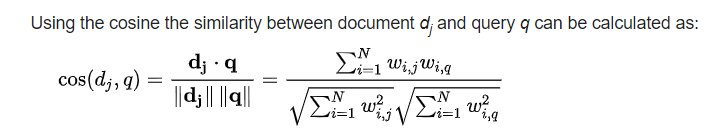

In [82]:
# calculate the cosine similarity and return two valued, the first one a sorted list that contains the index of top document
# the second one the correspond dictionary, where the keys are the documents and the attribute the correspond similarity
import numpy as np
def cosine_similarity(query, column, df, word_to_idx, idx_to_documents, idx_doc_tfIdf, idf_dict, doc_index_tf_idf):
  query_terms = word_tokenize(query)
  results = dict()
  q = []
  match = match_query(df, query, column, word_to_idx, idx_to_documents)

  if len(match) == 0: return dict(),[]
  for query_term in query_terms:
    index = word_to_idx[query_term]
    postings_list = idx_doc_tfIdf[index]
    query_term_tfidf = compute_tfidf_query(query, query_term, idf_dict)
    q.append(query_term_tfidf)
    for doc in list(match.index):
      for doc_tf_idf, tfidf in postings_list:
        if doc == doc_tf_idf:
          results[doc] = results.get(doc, 0) + query_term_tfidf * tfidf
  for doc in results:
    results[doc] = results[doc] / (np.linalg.norm(doc_index_tf_idf[doc]) * np.linalg.norm(q))
  return results, list(sorted(results.keys(), key=lambda x: results[x], reverse=True))

In [83]:
# compute the tfidf for the query
def compute_tfidf_query(query, term, idf_dict):
  query_terms = word_tokenize(query)
  words_occ = get_number_occurrences(query_terms)
  tf = words_occ[term] / len(query_terms)
  if term not in idf_dict:
    idf = 0
  else:
    idf = idf_dict[term]
  return tf * idf

In [84]:
query = 'saiyan race'
result_query = cosine_similarity(query,"animeDescription",df, word_to_idx, idx_to_documents, idx_doc_tfIdf, idf_dict, doc_index_tf_idf)
cosine_result = pd.concat([df.loc[result_query[1]],pd.Series(sorted(result_query[0].values(),reverse=True), index=result_query[1]).rename('Similarity')], axis=1)

In [85]:
cosine_result[['animeTitle','animeDescription','url','Similarity']]

,animeTitle,animeDescription,url,Similarity
16036,Dragon Ball Z Special 1: Tatta Hitori no Saish...,bardock son gokus father lowranking saiyan sol...,https://myanimelist.net/anime/986/Dragon_Ball_...,0.300722
5825,Dragon Ball Super: Broly,fortyone year ago planet vegeta home infamous ...,https://myanimelist.net/anime/36946/Dragon_Bal...,0.185366
16141,Dragon Ball Z,five year winning world martial arts tournamen...,https://myanimelist.net/anime/813/Dragon_Ball_Z,0.134706


#REQ 3

In [86]:
df['animeTitleLower'] =  df["animeTitle"].apply(filter_sentence)

In [87]:
# calculate the cosine similarity
def retrieve_cosine_similarity(query, column_name, df):
  query = filter_sentence(query)
  all_words = retrieve_word_column(column_name)
  word_to_idx, idx_to_word =  retrieve_word_index(all_words)
  idx_to_documents = invert_index(column_name, word_to_idx)
  idx_doc_tfIdf, idf_dict, doc_index_tf_idf = retrieve_TF_IDF_document(df[column_name], word_to_idx, idx_to_documents)
  result = cosine_similarity(query, column_name, df, word_to_idx, idx_to_documents, idx_doc_tfIdf, idf_dict, doc_index_tf_idf)
  return result

In [88]:
list_columns = ['animeTitle', 'animeType', 'animeNumEpisode', 'releaseDate', 'endDate', 'animeNumMembers', 'animeScore', 'animeUsers', 'animeRank', 'animePopularity', 'animeDescription', \
                'animeRelated', 'animeCharacters', 'animeVoices', 'animeStaff', 'url','animeTitleLower']

In [89]:
def find_match_req3(query, list_column, df):
  list_column.extend(["descriptionSimilarity","titleSimilarity"])
  column_normalize_bool = {"descriptionSimilarity":False, "titleSimilarity": False, "animeScore": False, "animeRank":True, "animePopularity": True, "animeNumMembers":False}
  column_weight = {"descriptionSimilarity": 0.1, "titleSimilarity": 0.4, "animeScore":0.2 ,"animeRank":0.2, "animePopularity": 0.05, "animeNumMembers":0.05}
  calculate_weight = recalculate_weight(column_weight, list_column)

  # cosine similarity for title
  result_query_title = retrieve_cosine_similarity(query, "animeTitleLower", df) 

  # cosine similarity for description
  result_query_description = retrieve_cosine_similarity(query, "animeDescription", df) 
  
  #we take the corresponding lines from the data frame
  cosine_result_1 = pd.concat([df.loc[result_query_title[1]],pd.Series(sorted(result_query_title[0].values(),reverse=True),\
                                                               index=result_query_title[1], dtype="float32").rename('titleSimilarity')], axis=1)
  
  #we take the corresponding lines from the data frame
  cosine_result_2 = pd.concat([df.loc[result_query_description[1]],pd.Series(sorted(result_query_description[0].values(),reverse=True),\
                                                               index=result_query_description[1], dtype="float32").rename('descriptionSimilarity')], axis=1)
  
  # join the two dataframe (list_columns is present in the previous cell)
  cosine_result = pd.merge(cosine_result_1, cosine_result_2,  how='outer', on=list_columns)

  # fill the null value with zero
  cosine_result = cosine_result.fillna(0)

  #when we go to match, it is likely that one of the two is not present, so we will not create the table with zero as default value 
  if "titleSimilarity" not in cosine_result.columns: cosine_result["titleSimilarity"] = 0
  if "descriptionSimilarity" not in cosine_result.columns: cosine_result["descriptionSimilarity"] = 0

  # column which contains the new similarity
  cosine_result['newSimilarity'] = 0
  for column in list_column:
    small_important = column_normalize_bool[column] #True or False
    value = normalize_column(cosine_result,column, calculate_weight[column],small_important) # calculate the weight of the column 
    cosine_result['newSimilarity'] += value #added value in the newSimilarity
  
  return  cosine_result.sort_values(by='newSimilarity',ascending=False)
  

In [90]:
#recalculate the weight based on the user's choice 
def recalculate_weight(diz_orig_weight, list_columns):
  print(diz_orig_weight, '\n',list_columns)
  sum = 0
  diz_new_weight = dict()
  for column in list_columns:
    sum += diz_orig_weight[column]
  for column in list_columns:
    diz_new_weight[column] = diz_orig_weight[column] / sum
  return diz_new_weight

In [91]:
# function useful to normalize the value
#small_important is a boolean, True it means that the smaller the value, the more important that value is, so we have to do `1 - value` to normalize 
def normalize_column(cosine_result,column_name, weight,small_important):
  max = cosine_result[column_name].max()
  if max == 0: return 0
  if small_important: return (1 - cosine_result[column_name] / max) * weight
  return (cosine_result[column_name] / max) * weight

To calculate the similarity, we didn't use just the description, but we add some different factors, each one with is own Weight. we use the 'titleSimilarity', 'the animeScore', 'the animeRank', 'the animePopularity' and 'the animeNumMembers'.

We believe that the 'titleSimilarity' is the most important factor, so it has the biggest weight.

The users choose the columns to use to calculate the similarity, the only two that is mandatory to choose are 'titleSimilarity' and 'descriptionSimilarity', the other four factors can enter or not in the calculate of the newSimilarity.
When the users doesn't choose all the columns, the weights are automatically updated with a proportion:

For example $0.3:0.7=x:1$ 

Where 0.3 is the weight of that column that we wanna update the weight and 0.7 is the sum of the weights of the columns chosen.

when we have all weights, we are going to calculate the new similarity, using this formula:
value / maxValueColumn * weight

where value is the cosine similarity for `animeTitle` or `animeDescription` and the other column are the respect value of the anime in that column.

The newSimilarity is the sum of the result optained in the previous step.

#Test 01

we do a test, with this value of weights:

*   descriptionSimilarity $\rightarrow$ 0.2
*   titleSimilarity $\rightarrow$ 0.3

*   animeScore $\rightarrow$ 0.15
*   animeRank $\rightarrow$ 0.15

*   animePopularity $\rightarrow$ 0.1
*   animeNumMembers $\rightarrow$ 0.1

The updated weights:

*   descriptionSimilarity $\rightarrow$ 0.286
*   titleSimilarity $\rightarrow$ 0.429

*   animePopularity $\rightarrow$ 0.143
*   animeNumMembers $\rightarrow$ 0.143

And now we obtain this similarity:

Dragon Ball Z: 0.406099

Dragon Ball Super Broly: 0.307207

Dragon Ball z Special 1: 0.297830


#Test 02
Now we change the columns choosen  by the user and we consider 'animeScore' and 'animeRank' as columns choosen, we use the same original weights of the last test but with different updates:

*   descriptionSimilarity $\rightarrow$ 0.25
*   titleSimilarity $\rightarrow$ 0.375

*   animeScore $\rightarrow$ 0.187
*   animeRank $\rightarrow$ 0.187


We obtain this value of similarity:

Dragon Ball Super Broly: 0.477065

Dragon Ball z: 0.440238

Dragon Ball Z Special 1: 0.423696

With this colummns chosen the similarity of all three animes grows consistently the anime with the highest similarity is again `Dragon Ball Z Special 1`.

In both the test 01 and test 02 the NewSimilarity of all the anime are better than which one calculated in point two because, as you can see in the cell below, we can find in the first cell(the result of the cosine similarity of the request 2.2) which contains value with $-1$, moreover our algorithm is based on this column if the user specified the column.

The cells below contains another test with different query


In [118]:
query = 'goku'
result_query_description = retrieve_cosine_similarity(query, "animeDescription", df)
cosine_result = pd.concat([df.loc[result_query_description[1]],pd.Series(sorted(result_query_description[0].values(),reverse=True),\
                                                               index=result_query_description[1], dtype="float32").rename('descriptionSimilarity')], axis=1)
cosine_result.head()

,animeTitle,animeType,animeNumEpisode,releaseDate,endDate,animeNumMembers,animeScore,animeUsers,animeRank,animePopularity,animeDescription,animeRelated,animeCharacters,animeVoices,animeStaff,url,animeTitleLower,descriptionSimilarity
1915,Son O-gong gwa Byeoldeul-ui Jeonjaeng,TV,64,2009-04-05,2010-07-04,263.0,-1.00,-1.0,13448.0,15053.0,story galactic hero goku,"['Fullmetal Alchemist', 'Fullmetal Alchemist: ...","['Elric, Edward', 'Elric, Alphonse', 'Mustang...","['Park, Romi', 'Kugimiya, Rie', 'Miki, Shinich...","[['Cook, Justin', 'Producer'], ['Yonai, Norito...",https://myanimelist.net/anime/16814/Son_O-gong...,son ogong gwa byeoldeului jeonjaeng,0.621845
4116,Dragon Ball Movie 4: Saikyou e no Michi,TV,64,2009-04-05,2010-07-04,51628.0,7.13,27582.0,3225.0,2465.0,retelling dragon balls origin different take m...,"['Fullmetal Alchemist', 'Fullmetal Alchemist: ...","['Elric, Edward', 'Elric, Alphonse', 'Mustang...","['Park, Romi', 'Kugimiya, Rie', 'Miki, Shinich...","[['Cook, Justin', 'Producer'], ['Yonai, Norito...",https://myanimelist.net/anime/893/Dragon_Ball_...,dragon ball movie 4 saikyou e michi,0.604225
3252,Dragon Ball Z: Summer Vacation Special,TV,64,2009-04-05,2010-07-04,11351.0,6.59,4477.0,5666.0,5058.0,one peaceful afternoon son family friend spend...,"['Fullmetal Alchemist', 'Fullmetal Alchemist: ...","['Elric, Edward', 'Elric, Alphonse', 'Mustang...","['Park, Romi', 'Kugimiya, Rie', 'Miki, Shinich...","[['Cook, Justin', 'Producer'], ['Yonai, Norito...",https://myanimelist.net/anime/22695/Dragon_Bal...,dragon ball z summer vacation special,0.503414
5030,Dragon Ball Z Movie 07: Kyokugen Battle!! Sand...,TV,64,2009-04-05,2010-07-04,103961.0,6.85,64806.0,4410.0,1572.0,dr geros androids 13 14 15 awakened laboratory...,"['Fullmetal Alchemist', 'Fullmetal Alchemist: ...","['Elric, Edward', 'Elric, Alphonse', 'Mustang...","['Park, Romi', 'Kugimiya, Rie', 'Miki, Shinich...","[['Cook, Justin', 'Producer'], ['Yonai, Norito...",https://myanimelist.net/anime/900/Dragon_Ball_...,dragon ball z movie 07 kyokugen battle sandai ...,0.462226
7730,Dragon Ball Z Movie 07: Kyokugen Battle!! Sand...,TV,64,2009-04-05,2010-07-04,103961.0,6.85,64806.0,4409.0,1572.0,dr geros androids 13 14 15 awakened laboratory...,"['Fullmetal Alchemist', 'Fullmetal Alchemist: ...","['Elric, Edward', 'Elric, Alphonse', 'Mustang...","['Park, Romi', 'Kugimiya, Rie', 'Miki, Shinich...","[['Cook, Justin', 'Producer'], ['Yonai, Norito...",https://myanimelist.net/anime/900/Dragon_Ball_...,dragon ball z movie 07 kyokugen battle sandai ...,0.462226


In [116]:
query = 'goku'
find = find_match_req3(query, ['animeNumMembers','animePopularity'], df)

{'descriptionSimilarity': 0.1, 'titleSimilarity': 0.4, 'animeScore': 0.2, 'animeRank': 0.2, 'animePopularity': 0.05, 'animeNumMembers': 0.05} 
 ['animeNumMembers', 'animePopularity', 'descriptionSimilarity', 'titleSimilarity']


In [117]:
find.head()

,animeTitle,animeType,animeNumEpisode,releaseDate,endDate,animeNumMembers,animeScore,animeUsers,animeRank,animePopularity,animeDescription,animeRelated,animeCharacters,animeVoices,animeStaff,url,animeTitleLower,titleSimilarity,descriptionSimilarity,newSimilarity
0,Goku Sayonara Zetsubou Sensei,TV,64,2009-04-05,2010-07-04,59619.0,7.84,28392.0,779.0,2265.0,sayonara zetsubou sensei ova,"['Fullmetal Alchemist', 'Fullmetal Alchemist: ...","['Elric, Edward', 'Elric, Alphonse', 'Mustang...","['Park, Romi', 'Kugimiya, Rie', 'Miki, Shinich...","[['Cook, Justin', 'Producer'], ['Yonai, Norito...",https://myanimelist.net/anime/4872/Goku_Sayona...,goku sayonara zetsubou sensei,0.607027,0.000000,0.740859
1,Dragon Ball Kai: Mirai ni Heiwa wo! Goku no Ta...,TV,64,2009-04-05,2010-07-04,41082.0,7.52,23051.0,1558.0,2766.0,special episode trunks going back future fight...,"['Fullmetal Alchemist', 'Fullmetal Alchemist: ...","['Elric, Edward', 'Elric, Alphonse', 'Mustang...","['Park, Romi', 'Kugimiya, Rie', 'Miki, Shinich...","[['Cook, Justin', 'Producer'], ['Yonai, Norito...",https://myanimelist.net/anime/11359/Dragon_Bal...,dragon ball kai mirai ni heiwa wo goku tamashi...,0.395872,0.000000,0.505128
3,Dragon Ball Movie 4: Saikyou e no Michi,TV,64,2009-04-05,2010-07-04,51628.0,7.13,27582.0,3225.0,2465.0,retelling dragon balls origin different take m...,"['Fullmetal Alchemist', 'Fullmetal Alchemist: ...","['Elric, Edward', 'Elric, Alphonse', 'Mustang...","['Park, Romi', 'Kugimiya, Rie', 'Miki, Shinich...","[['Cook, Justin', 'Producer'], ['Yonai, Norito...",https://myanimelist.net/anime/893/Dragon_Ball_...,dragon ball movie 4 saikyou e michi,0.000000,0.604225,0.234574
6,Dragon Ball Z Movie 07: Kyokugen Battle!! Sand...,TV,64,2009-04-05,2010-07-04,103961.0,6.85,64806.0,4409.0,1572.0,dr geros androids 13 14 15 awakened laboratory...,"['Fullmetal Alchemist', 'Fullmetal Alchemist: ...","['Elric, Edward', 'Elric, Alphonse', 'Mustang...","['Park, Romi', 'Kugimiya, Rie', 'Miki, Shinich...","[['Cook, Justin', 'Producer'], ['Yonai, Norito...",https://myanimelist.net/anime/900/Dragon_Ball_...,dragon ball z movie 07 kyokugen battle sandai ...,0.000000,0.462226,0.204442
5,Dragon Ball Z Movie 07: Kyokugen Battle!! Sand...,TV,64,2009-04-05,2010-07-04,103961.0,6.85,64806.0,4410.0,1572.0,dr geros androids 13 14 15 awakened laboratory...,"['Fullmetal Alchemist', 'Fullmetal Alchemist: ...","['Elric, Edward', 'Elric, Alphonse', 'Mustang...","['Park, Romi', 'Kugimiya, Rie', 'Miki, Shinich...","[['Cook, Justin', 'Producer'], ['Yonai, Norito...",https://myanimelist.net/anime/900/Dragon_Ball_...,dragon ball z movie 07 kyokugen battle sandai ...,0.000000,0.462226,0.204442


#REQ 5 THEORY


$L$ is the list of appointments given in input, where each element correspond to the number of minutes of the appointment.

$T$ is the new list, where in the last element we will find the sum of the maximum number of minutes that the personal trainer can do.

$i$ represents the $i$-th appointment in the list.

The idea is that when we fill the array with the sum of the appointments, the first one that we put in is given by the fact that it is the first that matches. Moreover, when we arrive at the second appointment, we choose the maximum between the first and the second appointment because we can't have two consecutive appointment. 

From the third we change methodology, because now we can take more than one appointment, so we will do: on $T[i]$ (in this case $i=3$) we will put the maximum between the previous($T[i-1]$) and the sum of $T[i] + T[i-2]$ (in this case we will put the maximum between the second appointment and the sum between the first and the third one). Continuing like this we will find in the last element the maximum number of minutes that a personal trainer could perform.


Below the cell with the pseudocode, and then the cell with the function `find_max` that return the list $T$.

Below we also show, how from the vector $T$, we can extrapolate the appointments that we have chosen, that is the optimal solution.

\begin{align}
        \text{T}(i) = \left\{
        \begin{array}{cl}
        l[0]& i = 0 \\
        max(l[i], l[i-1]) & i = 1 \\
        max(l[i-1],l[i-2] + l[i]) & otherwise
        \end{array}
        \right.
    \end{align} 

In [96]:
lista=[30,40,25,50,30,20]
def find_max(lista):
    if len(lista) == 1: # i == 0
        return lista[0]
    elif len(lista) == 2: # i == 1
        max(lista[1],lista[0])
    result = [x for x in lista]
    for i in range(2,len(lista)): # otherwise
        result[i] = max(result[i-1],result[i-2] + result[i])
    return result
print(find_max(lista))

[30, 40, 55, 90, 90, 110]


Now that we have the vector of the maximum sum of minutes for a personal trainer, we will go to extrapolate the appointments chosen. Here the variabile that we need:
- $c$, last element from the list of the appointments, so the sum of all the optimal appointments;
- $i$, the index that we use on the while to scroll backwards the list $T$, and it will be initialized as the index of the last element.

We start doing a backwards scroll from the list of the appointments $T$ to understand what we chosen.
The idea is based on the fact that if the last element is bigger than the penultimate, it means that the last appointment has been chosen, so we can add it to our list. Furthermore, we subtract from $c$ the number of minutes of the appointment chosen (we need this variable to understand if we choose the first element on the list of appointments or not) then we decrease of 2 positions our index $i$ because we know that the penultimate appointment wasn't chosen.
Consequentially, we arrive at the third last appointment and we repeat the same process to the end of the list.
If we are at the first element and $c > 0$, it means that we had chosen also the first element so we add it to the list of the appointments chosen.

In [97]:
def print_choises(lista_orginal, list_sum_appointment):
    result = []
    i = len(lista_orginal) -1
    c = list_sum_appointment[-1] # the sum of all appointment choises
    while(c > 0 and i > -1):
        if list_sum_appointment[i] > list_sum_appointment[i-1]:
            result.append(lista_orginal[i]) 
            c -= lista_orginal[i]
            i-=2
        elif i == 0:
            result.append(lista_orginal[i])
            c -= lista_orginal[0]
    result.reverse()
    return result

print_choises(lista, find_max(lista))

[40, 50, 20]